# Merge Scraped Data

In [ ]:
import os

# Defining the directory containing the PGN files
input_directory = r'C:\Users\edulo\OneDrive\Documentos\Loyalist\AIP\Week 4\PGN\Magnus Games PGN data\Magnus PGN data'
output_file = r'C:\Users\edulo\OneDrive\Documentos\Loyalist\AIP\Week 4\PGN\Magnus Games PGN data\Magnus_PGN_merged.pgn'

# Getting a list of all PGN files in the directory
pgn_files = [f for f in os.listdir(input_directory) if f.endswith('.pgn')]

# Initializing a list to store the content of all PGN files
all_games = []

# Looping through each PGN file and read its content
for pgn_file in pgn_files:
    with open(os.path.join(input_directory, pgn_file), 'r', encoding='utf-8') as file:
        all_games.append(file.read())

# Writing the combined content to the output file
with open(output_file, 'w', encoding='utf-8') as file:
    for game in all_games:
        file.write(game + '\n\n')

print(f'Merged {len(pgn_files)} PGN files into {output_file}')

# Filter Games with timestamp

In [ ]:
import re

# Paths to the input merged PGN file and the output filtered PGN file
merged_pgn_file = r'C:\Users\edulo\OneDrive\Documentos\Loyalist\AIP\Week 4\PGN\Magnus Games PGN data\Magnus_PGN_merged.pgn'
filtered_pgn_file = r'C:\Users\edulo\OneDrive\Documentos\Loyalist\AIP\Week 4\PGN\Magnus Games PGN data\Magnus_PGN_filtered.pgn'

# Function to check if a game has timestamps
def has_timestamps(game):
    return re.search(r'\[%clk \d{1,2}:\d{2}(:\d{2})?\]', game) is not None

# Read the merged PGN file
with open(merged_pgn_file, 'r', encoding='utf-8') as file:
    merged_pgn_content = file.read()

# Split the content into individual games based on '[Event ' tag
games = re.split(r'(\[Event .+?\n)', merged_pgn_content)
# This will create a list where every event and game are separate elements. We need to combine them correctly.

# Combine event tags with their corresponding games
combined_games = []
for i in range(0, len(games) - 1, 2):
    combined_game = games[i] + games[i + 1]
    combined_games.append(combined_game)

# Filter games that contain timestamps
filtered_games = [game for game in combined_games if has_timestamps(game)]

# Write the filtered games to the new PGN file
with open(filtered_pgn_file, 'w', encoding='utf-8') as file:
    for game in filtered_games:
        file.write(game.strip() + '\n\n')  # Ensure each game is separated by a blank line

print(f'Filtered games with timestamps have been saved to {filtered_pgn_file}')


# Feature eng

Creating Data Frame

In [1]:
import chess
import chess.pgn
import pandas as pd
import numpy as np
import re

# Function to parse PGN file and extract required data
def parse_pgn_file(pgn_file):
    df_data = []

    with open(pgn_file, 'r') as file:
        while True:
            game = chess.pgn.read_game(file)
            if game is None:
                break

            # Extract time control from headers
            time_control = game.headers.get("TimeControl", None)
            if time_control:
                initial_time = time_control.split('+')[0]
                initial_time = int(initial_time) if initial_time.isdigit() else None
            else:
                initial_time = None

            white_move_count = 1
            black_move_count = 1

            board = game.board()
            prev_time_white = f"0:{initial_time // 60:02}:{initial_time % 60:02}" if initial_time else None
            prev_time_black = f"0:{initial_time // 60:02}:{initial_time % 60:02}" if initial_time else None

            for node in game.mainline():
                move = node.move
                fen = board.fen()
                color = int(board.turn)
                move_san = str(board.piece_at(move.from_square)).upper() + \
                           chess.SQUARE_NAMES[move.from_square] + \
                           chess.SQUARE_NAMES[move.to_square]
                move_count = white_move_count if color == 0 else black_move_count

                # Extract timestamps from comment
                comment = node.comment
                time_left_white = prev_time_white
                time_left_black = prev_time_black
                if comment:
                    times = re.findall(r'\[%clk ([\d:]+)\]', comment)
                    if len(times) == 1:
                        if color == 0:
                            time_left_black = times[0]
                        else:
                            time_left_white = times[0]
                    elif len(times) == 2:
                        time_left_white = times[0]
                        time_left_black = times[1]

                df_data.append((fen, move_san, color, move_count, time_left_white, time_left_black))

                if color == 0:
                    white_move_count += 1
                    prev_time_black = time_left_black
                else:
                    black_move_count += 1
                    prev_time_white = time_left_white

                board.push(move)

    return df_data

# Path to the filtered PGN file
filtered_pgn_file = r'C:\Users\edulo\OneDrive\Documentos\Loyalist\AIP\Week 4\PGN\Magnus Games PGN data\Magnus_PGN_filtered.pgn'

# Parse the PGN file and get DataFrame data
df_data = parse_pgn_file(filtered_pgn_file)

# Create DataFrame
df = pd.DataFrame(df_data, columns=['Previous_FEN', 'Next_Move', 'Color', 'Move_Count', 'Time_Left_White', 'Time_Left_Black'])

In [2]:
# Convert time left columns to seconds
df['Time_Left_White'] = df['Time_Left_White'].apply(lambda x: None if x is None else sum(int(t) * 60 ** i for i, t in enumerate(reversed(x.split(':')))))
df['Time_Left_Black'] = df['Time_Left_Black'].apply(lambda x: None if x is None else sum(int(t) * 60 ** i for i, t in enumerate(reversed(x.split(':')))))

In [3]:
# Display DataFrame
print(df)

                                            Previous_FEN Next_Move  Color  \
0      rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...     Pd2d4      1   
1      rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR ...     Ng8f6      0   
2      rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBN...     Pc2c4      1   
3      rnbqkb1r/pppppppp/5n2/8/2PP4/8/PP2PPPP/RNBQKBN...     Pe7e6      0   
4      rnbqkb1r/pppp1ppp/4pn2/8/2PP4/8/PP2PPPP/RNBQKB...     Ng1f3      1   
...                                                  ...       ...    ...   
91003       2r5/6p1/5p2/2K2Pk1/1P5p/7P/5RP1/8 w - - 5 51     Kc5d6      1   
91004       2r5/6p1/3K1p2/5Pk1/1P5p/7P/5RP1/8 b - - 6 51     Rc8b8      0   
91005       1r6/6p1/3K1p2/5Pk1/1P5p/7P/5RP1/8 w - - 7 52     Rf2b2      1   
91006      1r6/6p1/3K1p2/5Pk1/1P5p/7P/1R4P1/8 b - - 8 52     Kg5f5      0   
91007       1r6/6p1/3K1p2/5k2/1P5p/7P/1R4P1/8 w - - 0 53     Pb4b5      1   

       Move_Count  Time_Left_White  Time_Left_Black  
0               1    

In [4]:
# Function to calculate the time taken for each move
def calculate_time_taken(df, increment):
    time_taken = []
    prev_time_white = None
    prev_time_black = None

    for index, row in df.iterrows():
        if row['Color'] == 1:  # White move
            if prev_time_white is None or row['Time_Left_White'] is None:
                time_taken.append(None)
            else:
                time_taken.append(prev_time_white + increment - row['Time_Left_White'])
            prev_time_white = row['Time_Left_White']
        else:  # Black move
            if prev_time_black is None or row['Time_Left_Black'] is None:
                time_taken.append(None)
            else:
                time_taken.append(prev_time_black + increment - row['Time_Left_Black'])
            prev_time_black = row['Time_Left_Black']

    df['Time_Taken'] = time_taken
    return df

# Extract the increment part from the time control, default to 0 if not present or invalid
time_control = chess.pgn.read_headers(open(filtered_pgn_file, 'r')).get("TimeControl", "0+0")
increment = int(time_control.split('+')[1]) if '+' in time_control and time_control.split('+')[1].isdigit() else 0

# Calculate the time taken and add the new column to the DataFrame
df = calculate_time_taken(df, increment)

# Set Time_Taken to 1 second for all rows where Move_Count is 1
df.loc[df['Move_Count'] == 1, 'Time_Taken'] = 1

# Display the updated DataFrame
print(df.head())

                                        Previous_FEN Next_Move  Color  \
0  rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...     Pd2d4      1   
1  rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR ...     Ng8f6      0   
2  rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBN...     Pc2c4      1   
3  rnbqkb1r/pppppppp/5n2/8/2PP4/8/PP2PPPP/RNBQKBN...     Pe7e6      0   
4  rnbqkb1r/pppp1ppp/4pn2/8/2PP4/8/PP2PPPP/RNBQKB...     Ng1f3      1   

   Move_Count  Time_Left_White  Time_Left_Black  Time_Taken  
0           1             1519           1500.0         1.0  
1           1             1519           1518.0         1.0  
2           2             1527           1518.0         2.0  
3           2             1527           1526.0         2.0  
4           3             1535           1526.0         2.0  


Drop rows where Time_Taken is below 0

In [6]:
# Drop rows where Time_Taken is below 0
df = df.drop(df[df['Time_Taken'] < 0].index)

# Display the updated DataFrame
print(df.head())

                                        Previous_FEN Next_Move  Color  \
0  rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...     Pd2d4      1   
1  rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR ...     Ng8f6      0   
2  rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBN...     Pc2c4      1   
3  rnbqkb1r/pppppppp/5n2/8/2PP4/8/PP2PPPP/RNBQKBN...     Pe7e6      0   
4  rnbqkb1r/pppp1ppp/4pn2/8/2PP4/8/PP2PPPP/RNBQKB...     Ng1f3      1   

   Move_Count  Time_Left_White  Time_Left_Black  Time_Taken  
0           1             1519           1500.0         1.0  
1           1             1519           1518.0         1.0  
2           2             1527           1518.0         2.0  
3           2             1527           1526.0         2.0  
4           3             1535           1526.0         2.0  


Using only target player information

In [8]:
# Drop rows where Color column is equal to 0
df = df[df['Color'] != 0]

In [10]:
# Function to convert move to label
def move_to_label(move):
    from_square = chess.parse_square(move[1:3])
    to_square = chess.parse_square(move[3:])
    return from_square * 64 + to_square

# Convert Next_Move column to labels
df['Next_Move'] = df['Next_Move'].apply(move_to_label)

In [21]:
from stockfish import Stockfish

# Initialize Stockfish
stockfish_path = "C:/Users/edulo/Documents/stockfish/stockfish-windows-x86-64.exe"
stockfish = Stockfish(stockfish_path)

# Function to get evaluation from Stockfish
def get_stockfish_evaluation(fen):
    stockfish.set_fen_position(fen)
    evaluation = stockfish.get_evaluation()
    if evaluation['type'] == 'cp':
        return evaluation['value'], None
    elif evaluation['type'] == 'mate':
        return None, evaluation['value']
    else:
        return None, None

# Add columns for cp evaluation and mate evaluation
df['CP_Evaluation'] = np.nan
df['Mate_Evaluation'] = np.nan

# Populate the new columns with Stockfish evaluations
for index, row in df.iterrows():
    cp_value, mate_value = get_stockfish_evaluation(row['Previous_FEN'])
    df.at[index, 'CP_Evaluation'] = cp_value
    df.at[index, 'Mate_Evaluation'] = mate_value

# Display the updated DataFrame
print(df.head())

                                        Previous_FEN  Next_Move  Color  \
0  rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...        731      1   
2  rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBN...        666      1   
4  rnbqkb1r/pppp1ppp/4pn2/8/2PP4/8/PP2PPPP/RNBQKB...        405      1   
6  rnbqkb1r/ppp2ppp/4pn2/3p4/2PP4/5N2/PP2PPPP/RNB...        918      1   
8  rnbqkb1r/ppp2ppp/4pn2/8/2pP4/5NP1/PP2PP1P/RNBQ...        334      1   

   Move_Count  Time_Left_White  Time_Left_Black  Time_Taken  CP_Evaluation  \
0           1             1519           1500.0         1.0           31.0   
2           2             1527           1518.0         2.0           33.0   
4           3             1535           1526.0         2.0           36.0   
6           4             1543           1534.0         2.0           30.0   
8           5             1551           1524.0         2.0           31.0   

   Mate_Evaluation  
0              NaN  
2              NaN  
4              NaN  
6 

In [25]:
# Function to convert board state to one-hot encoding
def board_to_one_hot(fen):
    board = chess.Board(fen)
    one_hot = np.zeros((8, 8, 12), dtype=np.int8)
    piece_map = {chess.PAWN: 0, chess.KNIGHT: 1, chess.BISHOP: 2,
                 chess.ROOK: 3, chess.QUEEN: 4, chess.KING: 5}
    for square in chess.scan_reversed(chess.BB_ALL):
        piece = board.piece_at(square)
        if piece is not None:
            piece_index = piece_map[piece.piece_type] + (6 if piece.color else 0)
            one_hot[chess.square_rank(square), chess.square_file(square), piece_index] = 1
    return one_hot

# Convert Previous_FEN column to one-hot encoding
df['Previous_FEN'] = df['Previous_FEN'].apply(board_to_one_hot)

In [27]:
# Display DataFrame
df.head()

,Previous_FEN,Next_Move,Color,Move_Count,Time_Left_White,Time_Left_Black,Time_Taken,CP_Evaluation,Mate_Evaluation
0,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0,...",731,1,1,1519,1500.0,1.0,31.0,NaN
2,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0,...",666,1,2,1527,1518.0,2.0,33.0,NaN
4,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0,...",405,1,3,1535,1526.0,2.0,36.0,NaN
6,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0,...",918,1,4,1543,1534.0,2.0,30.0,NaN
8,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0,...",334,1,5,1551,1524.0,2.0,31.0,NaN


Check for null values

In [30]:
# Check for null values
null_values = df.isnull().sum()
print(null_values)

Previous_FEN           0
Next_Move              0
Color                  0
Move_Count             0
Time_Left_White        0
Time_Left_Black       79
Time_Taken             0
CP_Evaluation        278
Mate_Evaluation    44314
dtype: int64


In [32]:
# Fill NaN values in the specified columns with 0
df['Time_Left_Black'] = df['Time_Left_Black'].fillna(0)
df['CP_Evaluation'] = df['CP_Evaluation'].fillna(0)
df['Mate_Evaluation'] = df['Mate_Evaluation'].fillna(0)

In [34]:
# Check for null values
null_values = df.isnull().sum()
print(null_values)

Previous_FEN       0
Next_Move          0
Color              0
Move_Count         0
Time_Left_White    0
Time_Left_Black    0
Time_Taken         0
CP_Evaluation      0
Mate_Evaluation    0
dtype: int64


In [36]:
# Print statistical information from dataset
print(df.describe())

          Next_Move    Color    Move_Count  Time_Left_White  Time_Left_Black  \
count  44592.000000  44592.0  44592.000000     44592.000000     44592.000000   
mean    1254.113361      1.0     27.308508       407.443936       369.063935   
std      929.930095      0.0     19.265612       937.915071       859.772372   
min        1.000000      1.0      1.000000         0.000000         0.000000   
25%      454.000000      1.0     12.000000        51.000000        28.000000   
50%     1080.000000      1.0     24.000000       141.000000       104.000000   
75%     1828.000000      1.0     38.000000       344.000000       289.000000   
max     4094.000000      1.0    135.000000     70758.000000      8261.000000   

         Time_Taken  CP_Evaluation  Mate_Evaluation  
count  44592.000000   44592.000000     44592.000000  
mean      28.433060      70.494394         0.023009  
std      347.362455     167.802256         0.406943  
min        0.000000   -1132.000000       -14.000000  
25%      

In [38]:
# Path to save the CSV file
csv_file_path = r'C:\Users\edulo\OneDrive\Documentos\Loyalist\AIP\Week 4\PGN\Magnus Games PGN data\Magnus_PGN_filtered.csv'

# Export DataFrame to CSV
df.to_csv(csv_file_path, index=False)

# Model Building

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

In [51]:
# Convert Previous_FEN column to numpy array
X_fen = np.array(df['Previous_FEN'].tolist())

# Normalize numeric features
scaler = StandardScaler()
numeric_columns = ['Move_Count', 'Time_Left_White', 'Time_Left_Black', 'CP_Evaluation', 'Mate_Evaluation', 'Next_Move']
X_numeric = df[numeric_columns].values
X_numeric = scaler.fit_transform(X_numeric)

# Define input layers
input_fen = Input(shape=(8, 8, 12))  # Adjust according to your FEN encoding
input_numeric = Input(shape=(6,))

# Convolutional layers for FEN input
x = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(input_fen)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Flatten()(x)

# Concatenate FEN and numeric features
x = Concatenate()([x, input_numeric])

# Fully connected layers
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='linear')(x)

# Create and compile the model
model = Model(inputs=[input_fen, input_numeric], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Cross-validation
kf = KFold(n_splits=5)
val_mae_scores = []
test_mae_scores = []

for train_index, val_index in kf.split(X_fen):
    X_train_fen, X_val_fen = X_fen[train_index], X_fen[val_index]
    X_train_numeric, X_val_numeric = X_numeric[train_index], X_numeric[val_index]
    y_train, y_val = df['CP_Evaluation'].values[train_index], df['CP_Evaluation'].values[val_index]
    
    history = model.fit([X_train_fen, X_train_numeric], y_train, validation_data=([X_val_fen, X_val_numeric], y_val),
                        epochs=100, batch_size=32, callbacks=[early_stopping])
    
    val_loss, val_mae = model.evaluate([X_val_fen, X_val_numeric], y_val)
    val_mae_scores.append(val_mae)

# Evaluate on test set
test_loss, test_mae = model.evaluate([X_test_fen, X_test_numeric], y_test)
print(f'Cross-Validation Mean Absolute Error: {np.mean(val_mae_scores)}')
print(f'Test Mean Absolute Error: {test_mae}')

Epoch 1/100
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 28994.0234 - mae: 102.7396 - val_loss: 46889.2617 - val_mae: 140.1212
Epoch 2/100
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 28587.1055 - mae: 100.6401 - val_loss: 44664.7734 - val_mae: 134.0480
Epoch 3/100
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 27857.2109 - mae: 97.8162 - val_loss: 41541.5000 - val_mae: 128.9921
Epoch 4/100
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 26210.9551 - mae: 97.6030 - val_loss: 38612.5898 - val_mae: 125.1419
Epoch 5/100
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 25918.5176 - mae: 99.6974 - val_loss: 36405.6133 - val_mae: 122.2533
Epoch 6/100
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 25347.7559 - mae: 100.2724 - val_loss: 35115.9180 - val_mae: 120.5650
Epoch 7/100
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 24529.9004 - mae: 99.3510 - val_loss: 34346.6211 - val_mae: 119.5306
Epoch 8/100
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 24559.1680

279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10930.8447 - mae: 34.9105
Test Mean Absolute Error: 35.0404
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test Mean Squared Error: 9799.8546
Test Root Mean Squared Error: 98.9942
Test R-squared (R2): 0.1006


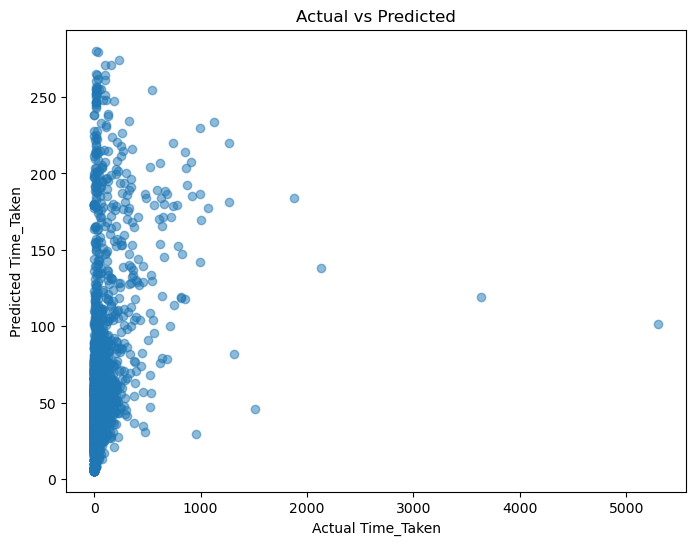

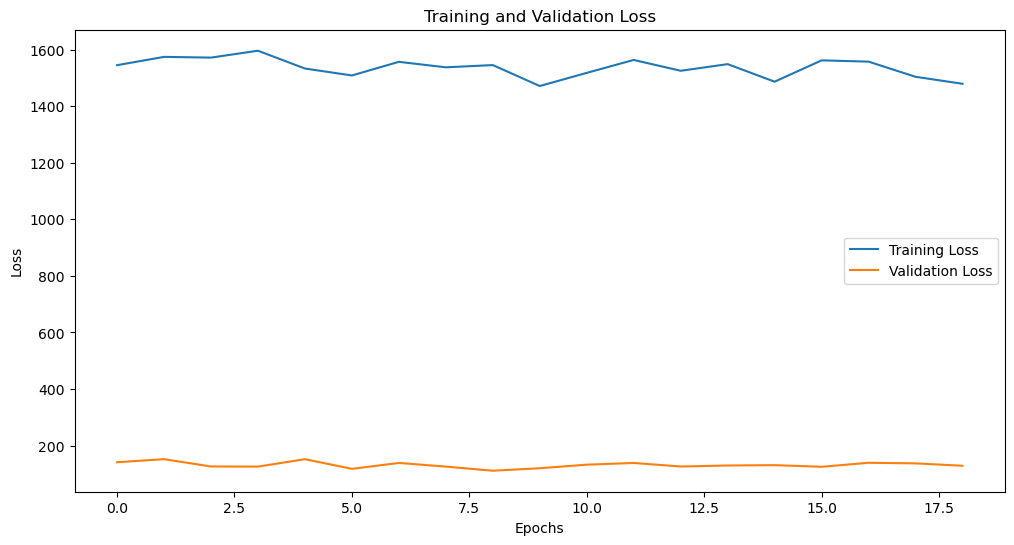

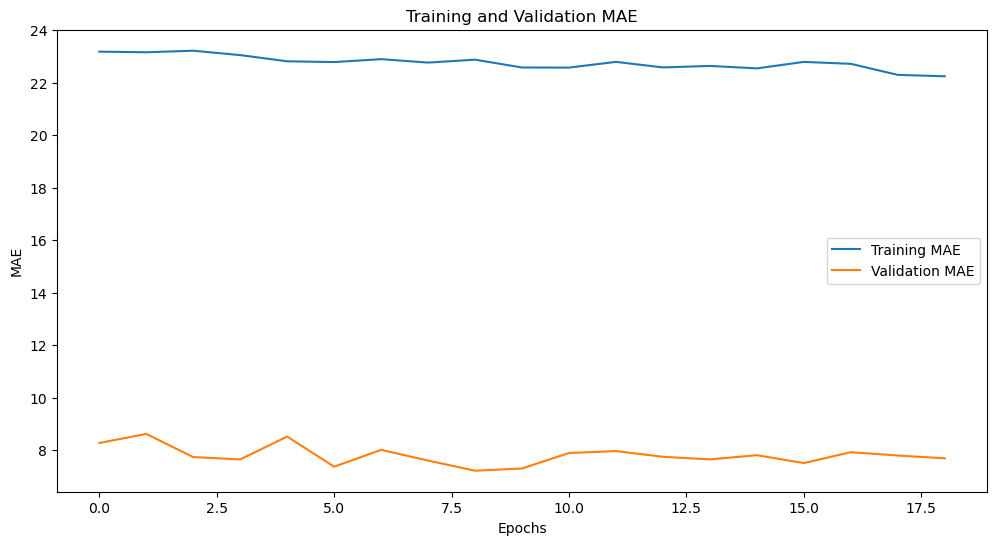

In [56]:
# Function to evaluate the model
def evaluate_model(model, X_test_fen, X_test_numeric, y_test):
    # Evaluate model
    loss, mae = model.evaluate([X_test_fen, X_test_numeric], y_test)
    print(f'Test Mean Absolute Error: {mae:.4f}')

    # Make predictions
    predictions = model.predict([X_test_fen, X_test_numeric]).flatten()

    # Calculate additional metrics
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    
    print(f'Test Mean Squared Error: {mse:.4f}')
    print(f'Test Root Mean Squared Error: {rmse:.4f}')
    print(f'Test R-squared (R2): {r2:.4f}')

    # Plot actual vs predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.xlabel('Actual Time_Taken')
    plt.ylabel('Predicted Time_Taken')
    plt.title('Actual vs Predicted')
    plt.show()

# Evaluate model
evaluate_model(model, X_test_fen, X_test_numeric, y_test)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

In [ ]:
# Convert Previous_FEN to numpy array
X_fen = np.array(df['Previous_FEN'].tolist())

# Normalize numeric features
scaler = StandardScaler()
X_numeric = df[['Move_Count', 'Time_Left_White', 'Time_Left_Black']].values
X_numeric = scaler.fit_transform(X_numeric)

# Combine inputs
input_fen = Input(shape=(8, 8, 12))
input_numeric = Input(shape=(3,))

# CNN layers for board state with additional layers
conv1 = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(input_fen)
conv2 = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(conv1)
conv3 = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(conv2)
flatten = Flatten()(conv3)

# Concatenate CNN output with numeric inputs
concatenated = Concatenate()([flatten, input_numeric])

# Dense layers for regression with moderate dropout and regularization, with additional dense layers
dense1 = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(concatenated)
dropout1 = Dropout(0.3)(dense1)
dense2 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(dropout1)
dropout2 = Dropout(0.3)(dense2)
dense3 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dropout2)
dropout3 = Dropout(0.3)(dense3)
output = Dense(1)(dropout3)  # Regression output for Time_Taken

# Prepare training and testing data
X_train_fen, X_test_fen, X_train_numeric, X_test_numeric, y_train, y_test = train_test_split(
    X_fen, X_numeric, df['Time_Taken'].values, test_size=0.2, random_state=42
)

# Define model
model = Model(inputs=[input_fen, input_numeric], outputs=output)

# Define optimizer with custom learning rate
optimizer = Adam(learning_rate=0.001)

# Compile model with Mean Squared Error as the loss function
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

# Train model
history = model.fit(
    [X_train_fen, X_train_numeric], y_train,
    epochs=50, batch_size=32,
    validation_data=([X_test_fen, X_test_numeric], y_test),
    callbacks=[early_stopping]
)

# Evaluate model
loss, mae = model.evaluate([X_test_fen, X_test_numeric], y_test)
print(f'Test Mean Absolute Error: {mae}')